In [1]:
using Plots
using Printf
using CovarianceWoodbury
using StatsBase
using BenchmarkTools


In [2]:
# data parameter
L = 256 	#length of the signal


# noise 
W = ones(L)	# precision of the i.i.d. noise
rank =  2	# rank of the covariance matrix (minus the diagonal)
U = ones(Float64,L,rank)
U[:,2] .= collect(range(-1,1,length=L));
U .+=  0.1 * randn(L,rank);


## Building the theoretical covariance matrix


In [3]:
Cth = WoodburyCovariance(W,U )

show(Cth)

256×256 WoodburyCovariance{Float64,2} with rank 2

`WoodburyCovariance` objects are `AbstractArray` with overloaded functions:  

In [4]:
println("The covariance matrix has  $(ndims(Cth)) dimensions")
println("Its size is: $(size(Cth))")
println("Its length is: $(length(Cth))")

The covariance matrix has  2 dimensions
Its size is: (256, 256)
Its length is: 65536


If the input space is of size `L` and `U` is of rank `K`, only `L*(K+1)+K^2` 
coefficients must be stored instead of at least `L(L+1)/2` for the full covariance matrix.

In [5]:
println("$(Base.summarysize((Cth))) vs $(Base.summarysize(collect(Cth)))")

6361 vs 524328


It can be converted to an `Array`:

In [6]:
typeof( collect(Cth))

Matrix{Float64} (alias for Array{Float64, 2})

The inverse of `WoodburyCovariance` and  can be applyied efficiently thank to the matrix inversion lemma:

In [7]:
x = randn(L)
@benchmark Cth\x


BenchmarkTools.Trial: 10000 samples with 8 evaluations.
 Range (min … max):  3.483 μs …  2.742 ms  ┊ GC (min … max):  0.00% … 99.58%
 Time  (median):     4.064 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   6.584 μs ± 65.876 μs  ┊ GC (mean ± σ):  26.30% ±  2.63%

  ▄▆▄▅█▇▅▃▂▁         ▂▁    ▁▃▄▄▄▃▂▂▂▁▁                       ▂
  ████████████▇▇▇███████▇▆▇█████████████▇▇▆▆▇▆▇▇▇▇▇▇▇▆▆▆▆▆▅▆ █
  3.48 μs      Histogram: log(frequency) by time     10.1 μs <

 Memory estimate: 6.73 KiB, allocs estimate: 12.

In [8]:
@benchmark $(collect(Cth))\x


BenchmarkTools.Trial: 2664 samples with 1 evaluation.
 Range (min … max):  949.271 μs …  10.056 ms  ┊ GC (min … max): 0.00% … 72.67%
 Time  (median):       1.722 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.868 ms ± 714.110 μs  ┊ GC (mean ± σ):  2.85% ±  7.00%

                    ▅██▅▃    ▂                                   
  ▃▂▂▁▃▄▅▃▂▄▃▃▄▄▄▄▄██████▇▅▆▇██▅▃▃▃▃▂▂▃▂▂▂▂▂▃▂▃▃▃▃▃▃▃▃▃▃▂▃▂▃▂▂▂ ▃
  949 μs           Histogram: frequency by time         3.16 ms <

 Memory estimate: 516.30 KiB, allocs estimate: 4.

# Estimation of the covariance matrix


### Simulating noise:

In [9]:

N = 1000 		# number of realizations for covariance estimation
correlated = zeros(L,N)
for k =1:rank
	correlated .+= U[:,k] *  randn(N)'
end
noise = 1 ./ W .* randn(L,N)  .+  correlated;



### Learning the covariance matrix
The diagonal `W` and the low rank  `U` matrices are learned from the data in the maximum likelihood sense.

In [10]:
Cest = buildCovariance(noise,rank);



### Evaluation of the approximation of the covariance matrix

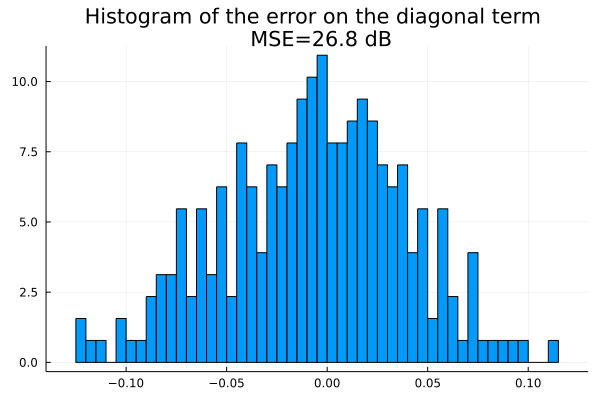

In [15]:

mseW = mean(abs2,Cest.W .- Cth.W)
histogram(Cth.W .- Cest.W, normalize= :pdf, bins=50, labels="",		
	title="Histogram of the error on the diagonal term \n MSE=$(@sprintf "%.1f dB" -10*log10(mseW))")


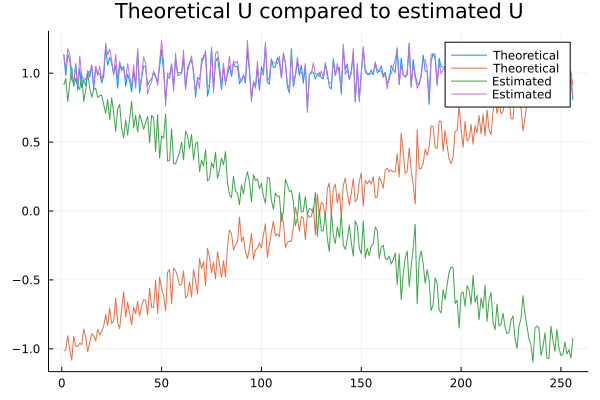

In [29]:
U_error = Cth.U[:,1:rank] .-  Cest.U
mseU = mean(abs2,U_error,dims=1)


figU = plot(Cth.U[:,1:rank],labels="Theoretical", title="Theoretical U compared to estimated U")
plot!(figU, Cest.U,labels="Estimated")

Note that there is a sign ambiguity in the estimation of the low rank matrix as
`U*U' == (-U)*(-U)'`

In [13]:
mseC = mean( abs2, Cest .- Cth)
"MSE on the covariance matrix  $(@sprintf "%.1f dB" -10*log10(mseC))"

"MSE on the covariance matrix  24.3 dB"